In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
file_path = 'customer_data.csv'  # Replace with your file path if needed
df = pd.read_csv(file_path)

# Inspect the dataset
print("Shape of the dataset:", df.shape)
print("\nMissing values in each column:")
print(df.isnull().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())
print("\nData types of each column:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe(include='all'))

# 2. Data Preprocessing
# Select numeric columns for scaling
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize a scaler (e.g., StandardScaler)
scaler = StandardScaler()

# Standardize the numeric features
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print("\nFirst 5 rows of the standardized dataset:")
print(df_scaled.head())


Shape of the dataset: (1000, 5)

Missing values in each column:
User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

Number of duplicate rows: 0

Data types of each column:
User ID          int64
Gender          object
Age              int64
AnnualSalary     int64
Purchased        int64
dtype: object

Summary statistics:
            User ID  Gender          Age   AnnualSalary    Purchased
count   1000.000000    1000  1000.000000    1000.000000  1000.000000
unique          NaN       2          NaN            NaN          NaN
top             NaN  Female          NaN            NaN          NaN
freq            NaN     516          NaN            NaN          NaN
mean     500.500000     NaN    40.106000   72689.000000     0.402000
std      288.819436     NaN    10.707073   34488.341867     0.490547
min        1.000000     NaN    18.000000   15000.000000     0.000000
25%      250.750000     NaN    32.000000   46375.000000     0.000000
50%  

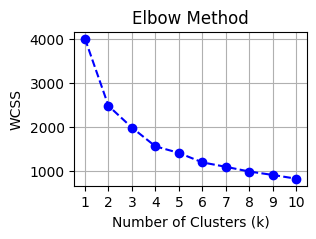

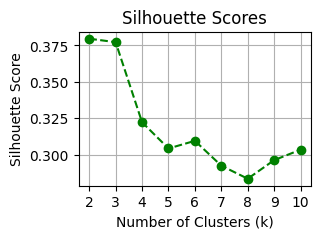

In [3]:
wcss = []  # Within-Cluster Sum of Squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(df_scaled[numeric_columns])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(3,2))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# Optional: Use the Silhouette Score to evaluate cluster quality
silhouette_scores = {}
for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    labels = kmeans.fit_predict(df_scaled[numeric_columns])
    silhouette_scores[k] = silhouette_score(df_scaled[numeric_columns], labels)

# Plot Silhouette Scores
plt.figure(figsize=(3,2))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='--', color='g')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Choose the optimal number of clusters (e.g., from the elbow point or highest silhouette score)
optimal_clusters = 4  # Replace with the observed optimal number

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, init='k-means++')

In [4]:
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[numeric_columns])

# Show cluster assignment
print("\nCluster labels assigned to the data:")
print(df_scaled[['Cluster']].value_counts())

# Save the clustered data (if needed)
clustered_data = df.copy()
clustered_data['Cluster'] = df_scaled['Cluster']
print("\nFirst 5 rows of the dataset with cluster labels:")
print(clustered_data.head())



Cluster labels assigned to the data:
Cluster
0          297
3          287
1          255
2          161
Name: count, dtype: int64

First 5 rows of the dataset with cluster labels:
   User ID Gender  Age  AnnualSalary  Purchased  Cluster
0      385   Male   35         20000          0        3
1      681   Male   40         43500          0        0
2      353   Male   49         74000          0        3
3      895   Male   40        107500          1        1
4      661   Male   25         79000          0        0


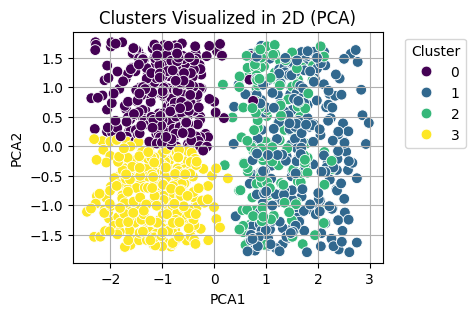

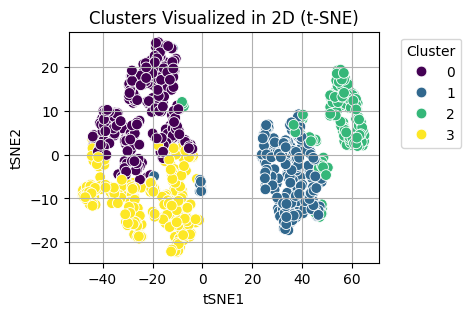

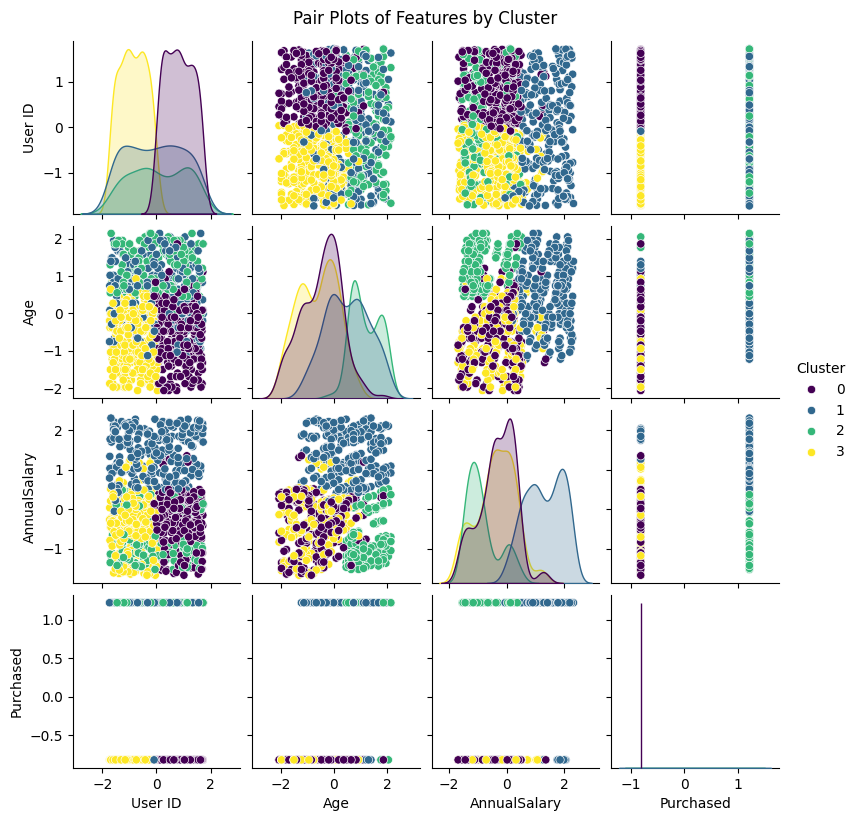

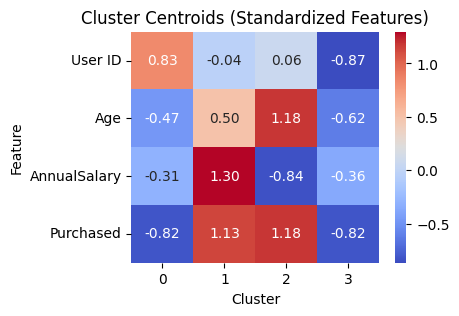

In [5]:
pca = PCA(n_components=2, random_state=42)
df_scaled['PCA1'] = pca.fit_transform(df_scaled[numeric_columns])[:, 0]
df_scaled['PCA2'] = pca.fit_transform(df_scaled[numeric_columns])[:, 1]

# 2D Scatter Plot using PCA
plt.figure(figsize=(4,3))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=df_scaled, palette='viridis', s=60
)
plt.title('Clusters Visualized in 2D (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Step 2: Reduce dimensions to 2D using t-SNE (optional, slower but captures local structure better)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
df_scaled['tSNE1'] = tsne.fit_transform(df_scaled[numeric_columns])[:, 0]
df_scaled['tSNE2'] = tsne.fit_transform(df_scaled[numeric_columns])[:, 1]

# 2D Scatter Plot using t-SNE
plt.figure(figsize=(4,3))
sns.scatterplot(
    x='tSNE1', y='tSNE2', hue='Cluster', data=df_scaled, palette='viridis', s=60
)
plt.title('Clusters Visualized in 2D (t-SNE)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Step 3: Pair Plots to visualize relationships between features within clusters
sns.pairplot(df_scaled, vars=numeric_columns, hue='Cluster', palette='viridis', diag_kind='kde', height=2)
plt.suptitle('Pair Plots of Features by Cluster', y=1.02)
plt.show()

# Step 4: Visualizing Centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_columns)

# Plot centroids
plt.figure(figsize=(4,3))
sns.heatmap(centroids.T, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Cluster Centroids (Standardized Features)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()
